In [36]:
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig, pipeline
from PIL import Image,ImageDraw, ImageFont
from glob import glob
from tqdm import tqdm

import random
import textwrap
import torch

In [ ]:
#inference function from Gemini
def caption(
    image: Image.Image,
    caption: str,
    padding: int = 20,
    font_size: int = 20,
    min_font_size: int = 8,
    font_path: str = None,
) -> Image.Image:

    draw = ImageDraw.Draw(image)

    # Load font helper
    def load_font(size):
        try:
            if font_path:
                return ImageFont.truetype(font_path, size)
            return ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", size)
        except:
            return ImageFont.load_default()

    # Wrap text to fit width
    def wrap_text(text, font, max_width):
        lines = []
        words = text.split()
        current_line = ""

        for word in words:
            test_line = f"{current_line} {word}".strip()
            bbox = draw.textbbox((0, 0), test_line, font=font)
            width = bbox[2] - bbox[0]

            if width <= max_width:
                current_line = test_line
            else:
                lines.append(current_line)
                current_line = word

        if current_line:
            lines.append(current_line)

        return lines

    max_text_width = image.width - (padding * 2)

    # Reduce font size until text fits nicely
    while font_size >= min_font_size:
        font = load_font(font_size)
        lines = wrap_text(caption, font, max_text_width)

        line_heights = []
        for line in lines:
            bbox = draw.textbbox((0, 0), line, font=font)
            line_heights.append(bbox[3] - bbox[1])

        total_text_height = sum(line_heights) + (len(lines) - 1) * 5

        # If reasonable height, break
        if total_text_height < image.height * 0.6:
            break

        font_size -= 2

    # Create new image
    new_height = image.height + total_text_height + (padding * 2)
    new_image = Image.new("RGB", (image.width, new_height), "white")
    draw_new = ImageDraw.Draw(new_image)

    # Draw wrapped text centered
    y = padding
    for line, line_height in zip(lines, line_heights):
        bbox = draw_new.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        x = (image.width - text_width) // 2
        draw_new.text((x, y), line, fill="black", font=font)
        y += line_height + 5

    # Paste original image
    new_image.paste(image, (0, total_text_height + (padding * 2)))

    return new_image

In [2]:
processor = AutoProcessor.from_pretrained("google/medgemma-1.5-4b-it")

The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


In [4]:
pipe = pipeline(
    "image-text-to-text",
    model="justacoderwhocodes/medgemma-dental-diagnosis-finetune",
    processor=processor,
    dtype=torch.bfloat16,
)

Loading weights: 100%|██████████| 883/883 [00:00<00:00, 1114.12it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight]                      


In [5]:
pipe.model.generation_config.do_sample = False
pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
processor.tokenizer.padding_side = "left"

In [7]:
filename = "dataset_diagnosis/extraction_img2_tooth_00645.jpg"
img = Image.open(filename)

In [ ]:
prompt_text = "Analyze this dental radiograph and provide findings."

In [30]:
messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": filename},
                {"type": "text", "text": prompt_text},
            ],
        },
]

formatted_input = processor.apply_chat_template( messages, add_generation_prompt=True, tokenize=False )

In [31]:
output = pipe(
    text=messages,
    max_new_tokens=150,
    return_full_text=False,
)

Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [32]:
predicted_text = output[0]["generated_text"]

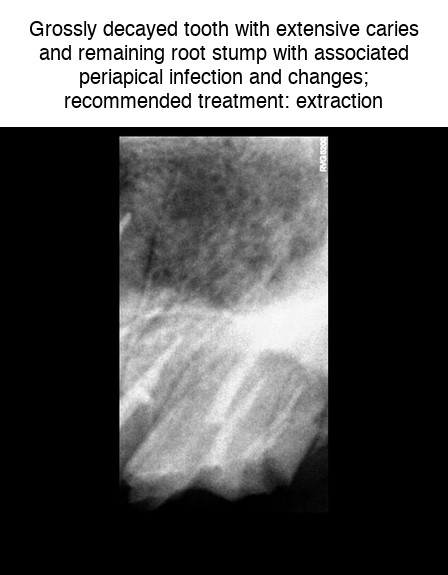

In [33]:
caption(img,predicted_text)

In [48]:
filenames = random.sample(glob("dataset_diagnosis/*.jpg"),30)

In [49]:
filenames[0]

'dataset_diagnosis/extraction_img107_tooth_00777.jpg'

In [50]:
for filename in tqdm(filenames):
    img = Image.open(filename)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": filename},
                {"type": "text", "text": prompt_text},
            ],
        },
    ]

    formatted_input = processor.apply_chat_template( messages, add_generation_prompt=True, tokenize=False )
    output = pipe( text=messages, max_new_tokens=150, return_full_text=False, )
    predicted_text = output[0]["generated_text"]
    captioned_image = caption(img,filename+"-"+predicted_text)
    captioned_image.save(filename.replace("dataset_diagnosis","check"))
    

100%|██████████| 30/30 [29:12<00:00, 58.40s/it]
